# Main profil optimization 

## Import


In [19]:
import os
from datetime import datetime
from time import time

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

import casadi as ca
import aerosandbox as asb
import aerosandbox.numpy as np
from aerosandbox.tools.pretty_plots import plt, show_plot, set_ticks  # sets some nice defaults


# Data extractions

In [20]:
# %% Import airfoil from .dat file
file_name = "Action-new April15.dat"

airfoil = asb.Airfoil(coordinates = (os.path.join(os.getcwd(), "Airfoils", file_name)))
kulfan_airfoil = airfoil.to_kulfan_airfoil()

#  %% For stability limit
limit_file_name = "Limit stability.dat"
airfoil_limit = asb.Airfoil(coordinates = (os.path.join(os.getcwd(), "Airfoils", limit_file_name)))
kulfan_airfoil_limit = airfoil_limit.to_kulfan_airfoil()

print(f'data extracted from : {file_name}\n')
print("________\n")

data extracted from : Action-new April15.dat

________



# Parameters

In [21]:
# %% Inputs
Re = 1.e6 #Upwind conditions
mach = 0.0
alpha_multipoint = np.arange(0,9, 0.5)
initial_guess_airfoil = kulfan_airfoil
initial_guess_airfoil.name = f'Initial Guess ({file_name})'

# %% To initialize var_alpha
initial_aero = initial_guess_airfoil.get_aero_from_neuralfoil(
    alpha=alpha_multipoint,
    Re=Re,
    mach=mach,
) 
CL_initial = initial_aero["CL"]

# Optimization

In [22]:
opti = asb.Opti()
print(f'computing for Re : {Re} , from "{initial_guess_airfoil.name}"...')
print("-------------------------------")

# %% variables
optimized_airfoil = asb.KulfanAirfoil(
    name="Optimized",
    lower_weights=opti.variable(
        init_guess=initial_guess_airfoil.lower_weights,
        lower_bound=-0.267,
        upper_bound=-0.1
    ),

    upper_weights=opti.variable(
        init_guess=initial_guess_airfoil.upper_weights,
        lower_bound=-0.5,
        upper_bound=0.5,
    ),

    TE_thickness=opti.variable(
        init_guess=initial_guess_airfoil.TE_thickness,
        lower_bound=0,
        upper_bound=1,
    ),

    leading_edge_weight=opti.variable(
        init_guess=initial_guess_airfoil.leading_edge_weight,
        lower_bound=-1,
        upper_bound=1,
    ),
)

# %% We want the algorithm to find the alpha that suit for each Cl
var_alpha = opti.variable(
    init_guess=np.degrees(CL_initial / (2 * np.pi)),
    lower_bound=0,
    upper_bound=10
)

# %% Cl objective
objective_aero = initial_guess_airfoil.get_aero_from_neuralfoil(
    alpha=var_alpha,
    Re=Re,
    mach=mach,
) 
CL_multipoint_targets = objective_aero["CL"]

# %% Get the aero coefficient from the optimized airfoil
aero = optimized_airfoil.get_aero_from_neuralfoil(
    alpha=var_alpha,
    Re=Re,
    mach=mach,
)     

# %% Get post apex coordinates -> Not necessarily useful
post_apex_up = optimized_airfoil.upper_coordinates(x_over_c=np.linspace(0.21, 1, 101))
post_apex_low = optimized_airfoil.lower_coordinates(x_over_c=np.linspace(0.21, 1, 101))

# %% Get stability limits
# limit_aero = airfoil_limit.get_aero_from_neuralfoil(
#     alpha=var_alpha,
#     Re=Re,
#     mach=mach,
# ) 
initial_aero = initial_guess_airfoil.get_aero_from_neuralfoil(
    alpha=var_alpha,
    Re=Re,
    mach=mach,
) 
Xcp_multipoint_targets = -initial_aero["CM"]/initial_aero["CL"] + 0.25

# %% Get the optimized airfoil stability
Xcp = -aero["CM"]/aero["CL"] + 0.25 # CM is calculated at 25% of the chord

# %% Constraints
opti.subject_to([
    # %% The airfoil should be positively thick
    optimized_airfoil.local_thickness() > 0,

    # %% The airfoil should follow a target polar
    aero["CL"][0] <= CL_multipoint_targets[0],
    # aero["CL"][0] <= CL_multipoint_targets[0],
    aero["CL"]/aero["CD"] >= objective_aero["CL"]/objective_aero["CD"], # Not necessarily useful

    # %% Impose the alpha to stay close to the initial values
    var_alpha <= alpha_multipoint+0.5,
    var_alpha >= alpha_multipoint-0.5,

    # %% The airfoil should be stable -> Try different conditions
    # Xcp[0] <= 0.26,
    # Xcp <= Xcp_multipoint_targets * 1.5,
    # Xcp >= Xcp_multipoint_targets,

    # Xcp <= (-objective_aero["CM"]/objective_aero["CL"] + 0.25) *1.1,
    # np.abs(np.diff(Xcp)) <= 0.003,
    # np.diff(Xcp)[0]>=-0.003,

    # %% The airfoil should be manufacturable -> Try different conditions
    np.diff(np.diff(optimized_airfoil.local_thickness())) < 0,
    # np.diff(np.diff(optimized_airfoil.local_camber())) < 0,
    np.diff(post_apex_up) < 0,
    np.diff(post_apex_low) > 0,

    # optimized_airfoil.local_thickness(0.2) >= 0.19,
    # np.abs(np.diff(optimized_airfoil.local_thickness())) < 0.05,

    # optimized_airfoil.local_thickness() <= 0.21,
    np.max(optimized_airfoil.local_thickness()) >= np.max(initial_guess_airfoil.local_thickness())*0.9,
    np.max(optimized_airfoil.local_thickness()) <= np.max(initial_guess_airfoil.local_thickness())*1.1,

    # optimized_airfoil.local_thickness() >= initial_guess_airfoil.local_thickness()*0.9,

    optimized_airfoil.local_camber() <= initial_guess_airfoil.local_camber() * 2,
    optimized_airfoil.local_camber() >= initial_guess_airfoil.local_camber() * 0.1,

    optimized_airfoil.upper_coordinates(x_over_c=1) == 0,
    optimized_airfoil.lower_coordinates(x_over_c=1) == 0,

    optimized_airfoil.TE_angle() <= initial_guess_airfoil.TE_angle(),

    # optimized_airfoil.TE_angle() >= initial_guess_airfoil.TE_angle()*0.9,
    # optimized_airfoil.leading_edge_weight >= initial_guess_airfoil.leading_edge_weight*0.95,

    # %% The airfoil should be stable -> Past conditions
    # aero["CM"] >= 0.03,
    # aero["CM"] >= 0.02, 
])

# # %% Constraint that makes the optimized airfoil shape "realistic" by Peter Sharpe
# get_wiggliness = lambda af: sum([
#     np.sum(np.diff(np.diff(array)) ** 2)
#     for array in [af.lower_weights, af.upper_weights]
# ])

# opti.subject_to(
#     get_wiggliness(optimized_airfoil) < 4 * get_wiggliness(initial_guess_airfoil)
# )

# %% Objective
# opti.minimize(-np.mean(aero["CL"])/np.mean(aero["CD"]))
opti.minimize(-np.abs(np.mean(aero["CD"]))) # -> Does not give the same results


# %% Solving
sol = opti.solve(
    behavior_on_failure="return_last",
    verbose=False
)
print(f'end optimisation for Re : {Re} , from "{initial_guess_airfoil.name}"')
print("-------------------------------")

# %% Get the results
optimized_airfoil = sol(optimized_airfoil)
aero = sol(aero)
find_alpha = sol.value(var_alpha)
objective_aero = sol.value(objective_aero)

computing for Re : 1000000.0 , from "Initial Guess (Action-new April15.dat)"...
-------------------------------
end optimisation for Re : 1000000.0 , from "Initial Guess (Action-new April15.dat)"
-------------------------------


# Plotting

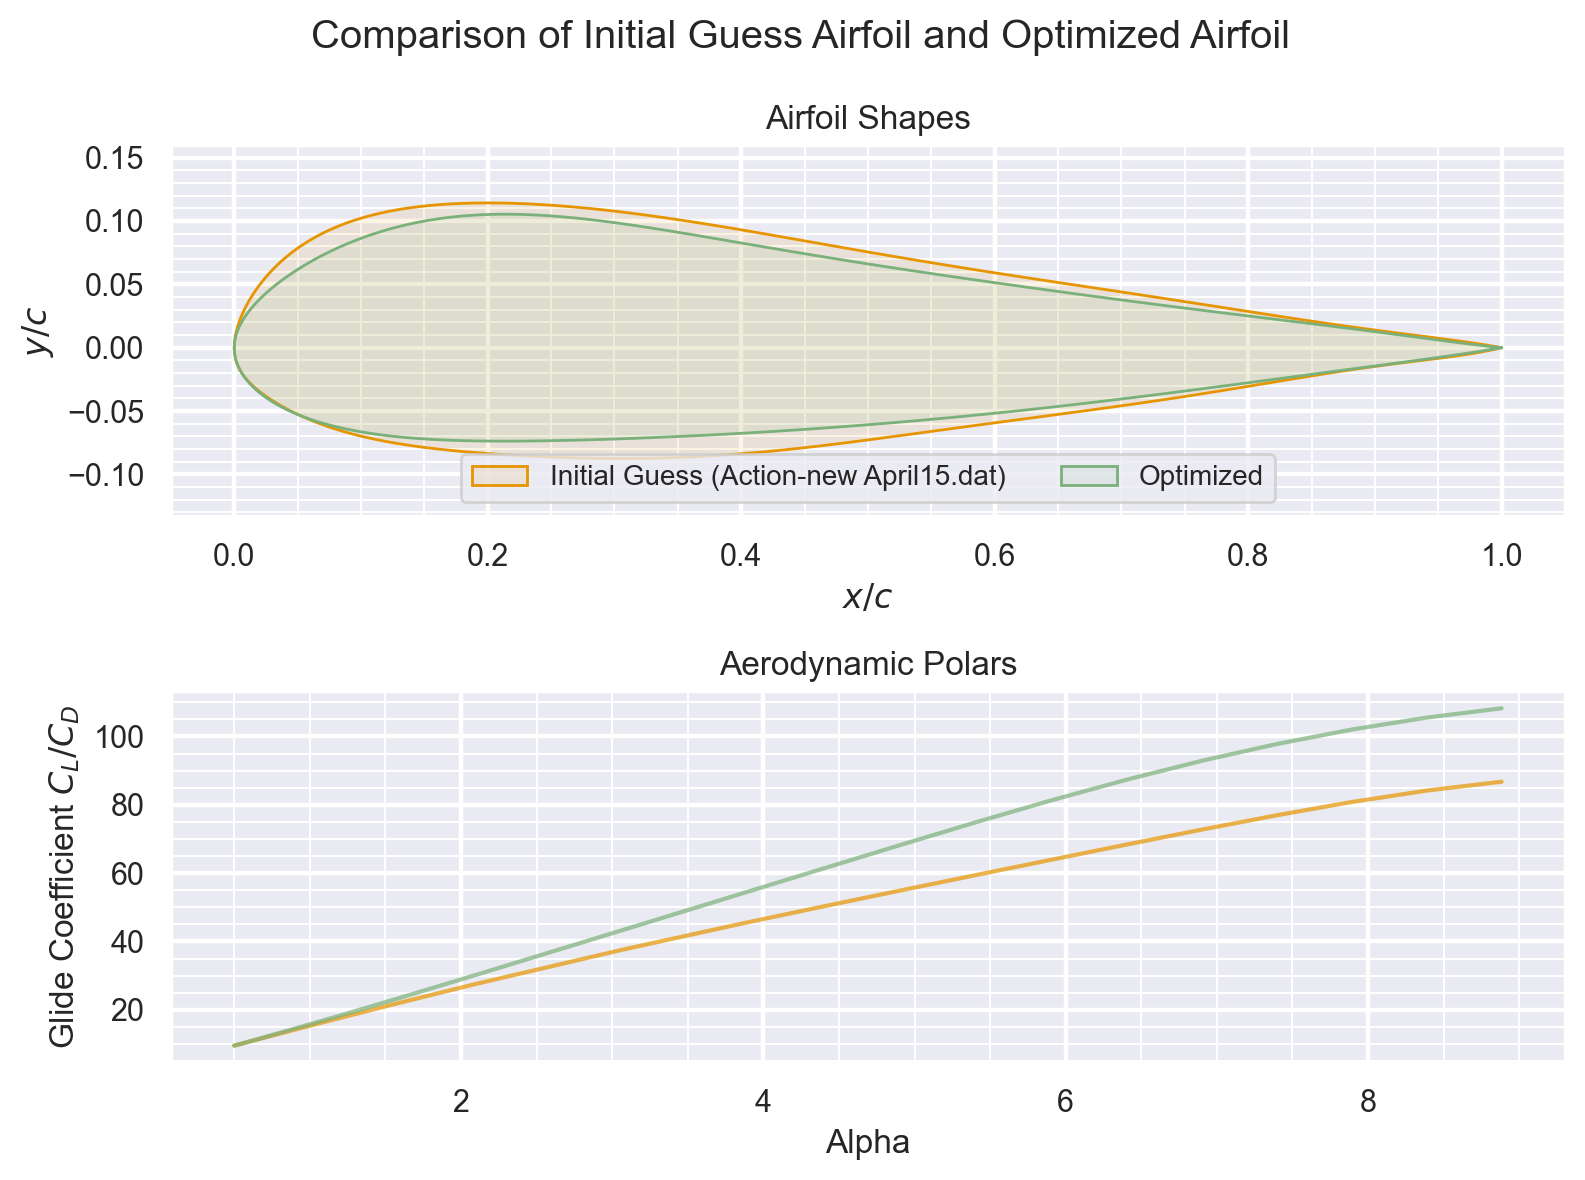

'Optimized\n1.000000 0.000000\n0.999938 0.000006\n0.999751 0.000025\n0.999439 0.000056\n0.999003 0.000100\n0.998443 0.000157\n0.997759 0.000228\n0.996950 0.000311\n0.996018 0.000409\n0.994962 0.000521\n0.993782 0.000647\n0.992480 0.000788\n0.991055 0.000945\n0.989507 0.001117\n0.987838 0.001306\n0.986046 0.001511\n0.984134 0.001733\n0.982101 0.001973\n0.979948 0.002229\n0.977675 0.002504\n0.975284 0.002797\n0.972774 0.003107\n0.970146 0.003436\n0.967400 0.003783\n0.964539 0.004148\n0.961561 0.004531\n0.958469 0.004931\n0.955262 0.005349\n0.951942 0.005783\n0.948509 0.006235\n0.944964 0.006702\n0.941309 0.007186\n0.937544 0.007684\n0.933669 0.008197\n0.929686 0.008725\n0.925597 0.009265\n0.921401 0.009819\n0.917100 0.010384\n0.912695 0.010962\n0.908188 0.011550\n0.903579 0.012150\n0.898869 0.012759\n0.894059 0.013378\n0.889152 0.014006\n0.884147 0.014644\n0.879047 0.015290\n0.873852 0.015944\n0.868565 0.016607\n0.863185 0.017278\n0.857715 0.017958\n0.852155 0.018646\n0.846508 0.019342\n

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
# optimized_airfoil.lower_weights = initial_guess_airfoil.lower_weights

for i, af in enumerate([
    initial_guess_airfoil,
    optimized_airfoil,
]):
    color = p.adjust_lightness(["orange", "darkseagreen", "dodgerblue"][i], 0.9)

    ax[0].fill(
        af.x(), af.y(),
        facecolor=(*color, 0.1),
        edgecolor=(*color, 1),
        linewidth=1,
        label=af.name
    )
    nf_aero = af.get_aero_from_neuralfoil(
        alpha=find_alpha,
        Re=Re,
        mach=mach,
    )
    ax[1].plot(
        find_alpha, nf_aero["CL"]/nf_aero["CD"],  #"--",
        color=color, alpha=0.7
    )
ax[0].legend(fontsize=10, loc="lower center", ncol=3)
ax[0].set_title("Airfoil Shapes")
ax[0].set_xlabel("$x/c$")
ax[0].set_ylabel("$y/c$")
ax[0].axis('equal')

ax[1].set_title("Aerodynamic Polars")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Glide Coefficient $C_L / C_D$")
p.show_plot("Comparison of Initial Guess Airfoil and Optimized Airfoil", legend=False)

optimized_airfoil.to_airfoil().write_dat(filepath = f'./Airfoils/{optimized_airfoil.name}.dat')

# Stability

data extracted from : Action New HLV4_1.dat

data extracted from : Action-new April15.dat

data extracted from : Limit stability.dat

data extracted from : Optimized.dat

data extracted from : R1 V4.dat



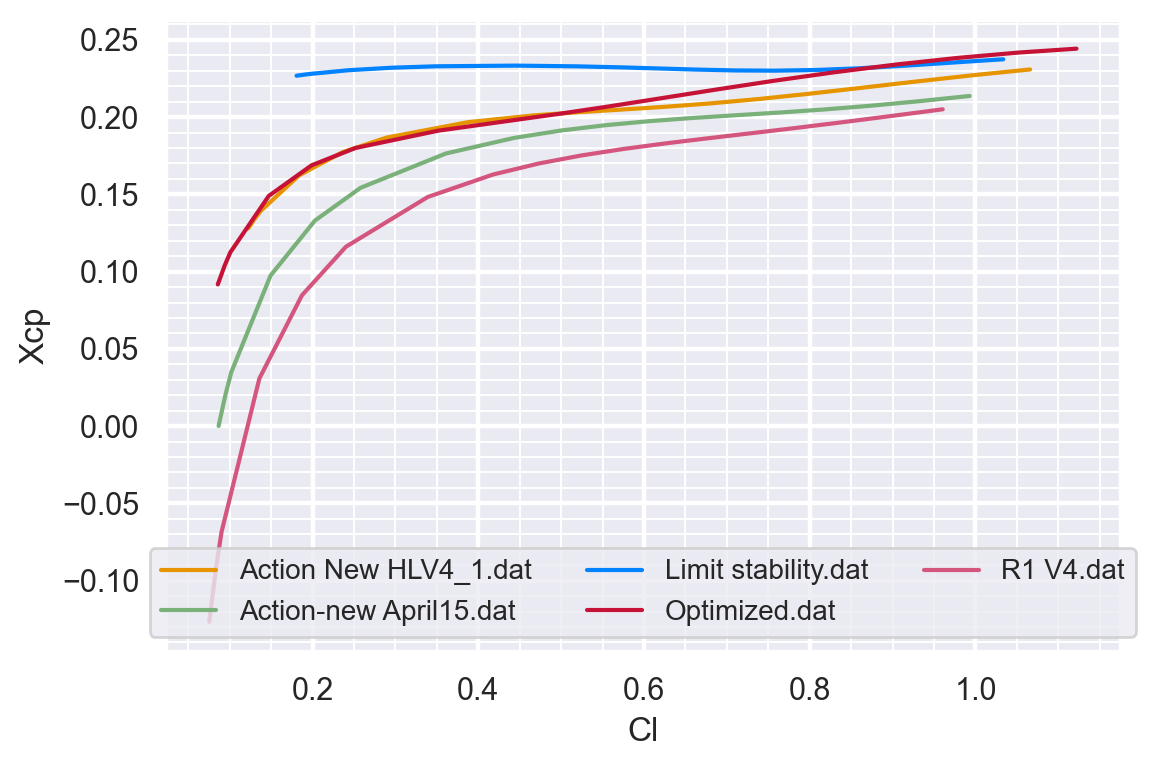

In [24]:
folder_name = "Airfoils"
list_results = []
Re = 1.3e6 #Upwind conditions
mach = 0.0

# %% Use Xfoil on each airfoil
for file in os.listdir(folder_name):
    airfoil = asb.Airfoil(coordinates = (os.path.join(os.getcwd(), "Airfoils", file)), name=file)
    airfoil.to_kulfan_airfoil()
    print(f'data extracted from : {file}\n')

    aero = airfoil.get_aero_from_neuralfoil(
        alpha=find_alpha,
        Re=Re,
        mach=mach,
    ) 

    results = {
        "Xcp":-aero["CM"]/aero["CL"] + 0.25,
        "Cl":aero["CL"],
        "alpha":find_alpha,
        "name":airfoil.name
    }
    list_results.append(results)

# %% Plot the results
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

for i, af in enumerate(
    list_results
):
    color = p.adjust_lightness(["orange", "darkseagreen", "dodgerblue", "crimson", "palevioletred", "gray", "black"][i], 0.9)
    ax.plot(
        af["Cl"],af["Xcp"],
        # af["alpha"],af["Xcp"],
        color=color,
        label=af["name"],
    )

ax.legend(fontsize=10, loc="lower center", ncol=3)
ax.set_xlabel("Cl")
ax.set_ylabel("Xcp")

p.show_plot("", legend=False)

## DO NOT TAKE INTO ACCOUNT WHAT'S NEXT

## Post treatment .dat file for XFLR5

In [25]:
with open('Airfoils/Optimized.dat', 'r') as fr:
        # reading line by line
        lines = fr.readlines()
     
        # opening in writing mode
        with open('Airfoils/Optimized.dat', 'w') as fw:
            for i,line in enumerate(lines):
               
                # we want to remove few lines
                if i%2 == 0 or i==1 or i==len(lines)-1:
                    fw.write(line)
    

## To create a .dat profil file with more coordinates

In [26]:
# Optimized = asb.Airfoil(coordinates = (os.path.join(os.getcwd(), "Results optimized", 'Optimized.dat')))
# up_co = Optimized.upper_coordinates()
# Satori3 = asb.Airfoil(coordinates = (os.path.join(os.getcwd(), "Airfoils", 'R1 V5 Satori 3.dat')))
# lo_co = Satori3.lower_coordinates()

# coordinates = np.zeros((len(up_co)+len(lo_co)-1,2))
# for i in range(len(coordinates)):
#     if i<len(up_co):
#         coordinates[i] = up_co[i]
#     else :
#          coordinates[i] = lo_co[i-len(up_co)+1]
      
# OptimizedXSat3 = asb.Airfoil(coordinates = coordinates)
# OptimizedXSat3.name = "OptimizedXSat3"
# # OptimizedXSat3.upper_coordinates = Optimized.upper_coordinates()
# # test = asb.Airfoil(coordinates = np.concatenate(Optimized.upper_coordinates(), Optimized.lower_coordinates()))
# OptimizedXSat3 = OptimizedXSat3.to_kulfan_airfoil()
# OptimizedXSat3 = OptimizedXSat3.to_airfoil()

# OptimizedXSat3.write_dat(filepath = f'./Results optimized/OptimizedXSat3.dat')

# with open('Results optimized/OptimizedXSat3.dat', 'r') as fr:
#         # reading line by line
#         lines = fr.readlines()
     
#         # opening in writing mode
#         with open('Results optimized/OptimizedXSat3.dat', 'w') as fw:
#             for i,line in enumerate(lines):
               
#                 # we want to remove 5th line
#                 if i%2 == 0 or i==1 or i==len(lines)-1:
#                     fw.write(line)